In [1]:
import os
import sys
from tqdm.notebook import tqdm
from IPython.display import clear_output

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [2]:
from MatSamp import *
import matplotlib.pyplot as plt
import igraph as ig
import networkx as nx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle

plt.rcParams.update(
    {"text.usetex": True, "font.family": "STIXGeneral", "mathtext.fontset": "stix"}
)

visual_style = {
    "vertex_size": 5,
    "vertex_color": "white",
    "vertex_frame_width": 1,
    "edge_width": 0.5,
    "bbox": (400, 400),  # Size of the plot canvas
    "margin": 20,
    "vertex_label_color": "black",
}

In [3]:
n = 16
p = np.round(1.1 * np.log(n) / n, 2)
#print(n, p)
net = ig.Graph.Erdos_Renyi(n=n, p=p)
#net = ig.Graph.K_Regular(n=n, k=4)

-0.2623872458934784 (39, 3) 154


Text(0.5, 1.0, 'r=-0.26')

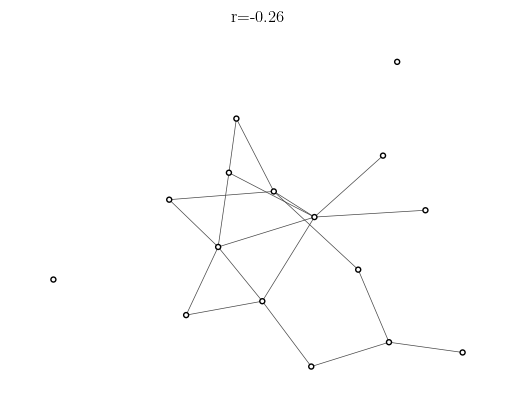

In [4]:
A = ig_to_A(net)
SNet = MatSamp(A, False)

deg = SNet.deg
n = SNet.n

motif_list = [(3, 2), (3, 3)]
org_r, org_motif, org_checker = (
    SNet.assortativity_coeff(),
    SNet.count_motif(),
    SNet.count_checker(),
)
print(org_r, org_motif, np.sum(org_checker))

fig, ax = plt.subplots()
ig.plot(net, target=ax, **visual_style)
ax.set_title(r"r={:.2f}".format(net.assortativity_degree(directed=False)))

In [5]:
A = ig_to_A(net)
SNet = MatSamp(A, False)

In [6]:
np.random.seed(1)
random.seed(1)

93 bins
93


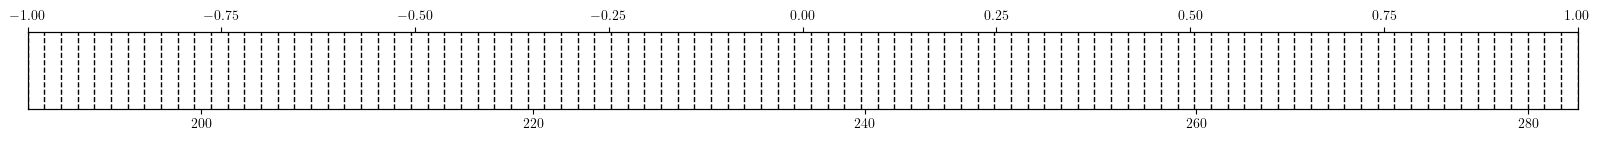

In [7]:
steps = (2 * SNet.M3 - 2 * SNet.M1)

step_size = 1

bins_edge = np.linspace(
    -SNet.M3 + 2 * SNet.M1,
    SNet.M3,
    int(steps / step_size) + 1,
)

bins_center = (bins_edge[1:] + bins_edge[:-1])/2

bin_cnt = len(bins_edge) - 1
print(
    "{:d} bins".format(
        bin_cnt
    )
)

fig, ax = plt.subplots(figsize=(20, 1))
ax.set_yticks([])
for x in bins_edge:
    ax.axvline(x=x, color="k", linestyle="--", linewidth=1)
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xlim([-SNet.M3 + 2 * SNet.M1, SNet.M3])
ax2 = ax.twiny()
ax2.set_xlim([-1, 1])
print(bin_cnt)

In [11]:
H_star = {}
H = {}
S = np.zeros(bin_cnt)
cnt = 0
tunnel = 0
tunnelFlag = -1
tunnelCnt = 10
finit = 1#np.exp(0)
ffinal = 1e-5
f = finit
tunnel_threshold = 0
step = 0

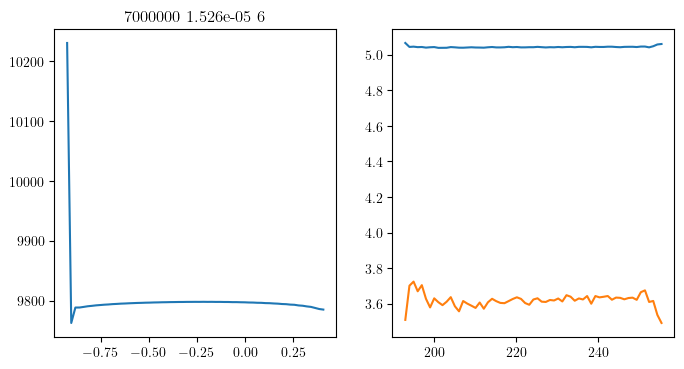

16    7129137 1.52588e-05 10


  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
pbar = tqdm(total=tunnelCnt)
# SNet.trackCheckerboard = True


while f > ffinal:
    # cnt += 1

    # if rmin <= SNet.assortativity_coeff() <= rmax:
    swt = SNet.next("rand")

    # if swt[0]==-1:
    #     continue
    cnt += 1
    # if rmin <= SNet.assort_after_swt(swt) <= rmax:
    M2cur = SNet.M2
    M2nxt = SNet.M2_after_swt(swt)
    curidx = np.searchsorted(bins_center, SNet.M2, side="right") - 1
    nxtidx = np.searchsorted(bins_center, M2nxt, side="right") - 1

    Scur = S[curidx] + (S[curidx + 1] - S[curidx]) * \
        (M2cur - bins_center[curidx]) / (bins_center[curidx + 1] - bins_center[curidx])

    Snxt = S[nxtidx] + (S[nxtidx + 1] - S[nxtidx]) * \
        (M2nxt - bins_center[nxtidx]) / (bins_center[nxtidx + 1] - bins_center[nxtidx])

    if np.log(np.random.rand()) < Scur - Snxt:
        SNet.switch(swt)

    bin_idx = np.searchsorted(bins_edge, SNet.M2, side="right") - 1
    if not (bin_idx in H):
        H[bin_idx] = 0
    if not (bin_idx in H_star):
        H_star[bin_idx] = 0

    H[bin_idx] += 1
    H_star[bin_idx] += 1
    S[bin_idx] += f / (bins_edge[bin_idx + 1] - bins_edge[bin_idx])

    bmin = min(H_star)
    bmax = max(H_star)
    # print(bmax)
    # print(bmax - (bin_cnt) * tunnel_threshold / 100)
    if (
        tunnelFlag == -1
        and bin_idx >= bmax - (bmax - bmin) * tunnel_threshold / 100
        #and SNet.assortativity_coeff() >= 0.5
    ):

        tunnel += 1
        pbar.update(1)
        tunnelFlag = 1

    elif (
        tunnelFlag == 1
        and bin_idx <= bmin + (bmax - bmin) * tunnel_threshold / 100
        #and SNet.assortativity_coeff() <= -0.5
    ):
        tunnelFlag = -1

    if tunnel >= tunnelCnt:
        print(
            "{:2d} {:10d} {:10.5e} {:1d}".format(step, cnt, f, tunnel),
        )
        pbar = tqdm(total=tunnelCnt)
        tunnel = 0
        tunnelFlag = -1
        if f / 2 > ffinal:
            H = {}
        f = f / 2
        step += 1

    if cnt % 1000000 == 0:
        clear_output(wait=True)
        mx = np.max(S)
        S_sum = mx + np.log(np.sum(np.exp(S - mx)))
        fig,ax = plt.subplots(1,2,figsize=(8,4))
        ax[0].plot((bins_center[S != 0] - SNet.M1) / (SNet.M3 - SNet.M1), S[S != 0])
        ax[0].set_title("{:d} {:10.3e} {:d} ".format(cnt, f, tunnel))

        data = [(i, j) for i, j in sorted(H_star.items())]
        datax = [(bins_edge[i[0]] + bins_edge[i[0] + 1]) / 2 for i in data]
        datay = [i[1] / (bins_edge[i[0] + 1] - bins_edge[i[0]]) for i in data]
        ax[1].plot(datax, np.log10(datay))
        data = [(i, j) for i, j in sorted(H.items())]
        datax = [(bins_edge[i[0]] + bins_edge[i[0] + 1]) / 2 for i in data]
        datay = [i[1] / (bins_edge[i[0] + 1] - bins_edge[i[0]]) for i in data]
        ax[1].plot(datax, np.log10(datay))

        plt.show()
# print(
#     "{:10d} {:10d} {:10d} {:.3f} {:.3f}".format(cnt, bmin,bmax,rmin,rmax ),
# )

[    0.             0.             0.         10230.82312372
  9762.426818    9788.25308183  9788.28394575  9789.31516177
  9790.39826804  9791.0833619   9791.89427972  9792.42587381
  9793.00928224  9793.4023303   9793.96689853  9794.31690715
  9794.76207318  9795.02727815  9795.38102141  9795.64545212
  9795.94171836  9796.1027785   9796.36742175  9796.50220278
  9796.74668505  9796.87258492  9797.0820891   9797.17669998
  9797.34334689  9797.41462386  9797.5499666   9797.57402922
  9797.69466112  9797.71922472  9797.77724827  9797.73697185
  9797.8352111   9797.72276201  9797.79507131  9797.66498136
  9797.69472184  9797.54642932  9797.53656137  9797.31178463
  9797.3120579   9797.10070158  9796.97984195  9796.68512422
  9796.59180377  9796.22974107  9796.12961932  9795.6703649
  9795.53570533  9795.07154729  9794.75153724  9794.15496649
  9793.88850146  9793.17152653  9792.87196591  9791.7938088
  9791.29397433  9790.16052633  9789.37245661  9787.60493965
  9785.7809932   9784.8281

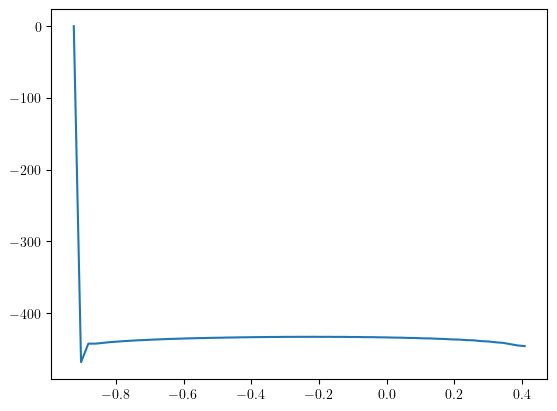

In [15]:
mx = np.max(S)
S_sum = mx + np.log(np.sum(np.exp(S - mx)))
plt.plot((bins_center[S != 0]-SNet.M1)/(SNet.M3-SNet.M1),(S-S_sum)[S != 0])
print(S)

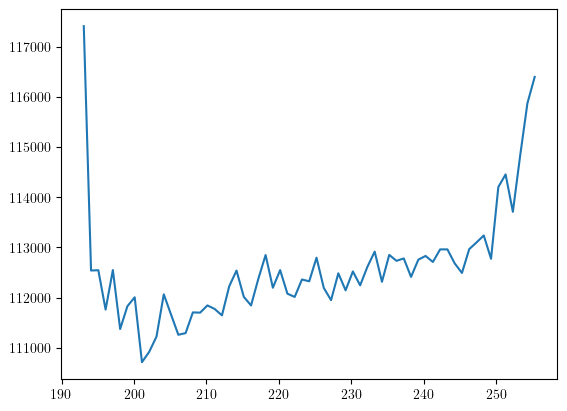

In [16]:
data = [(i, j) for i, j in sorted(H_star.items())]
datax = [(bins_edge[i[0]] + bins_edge[i[0] + 1]) / 2 for i in data]
datay = [i[1] / (bins_edge[i[0] + 1] - bins_edge[i[0]]) for i in data]
plt.plot(datax, datay)

In [26]:
A = ig_to_A(net)
SNet = MatSamp(A, False)
Strack = []
sample_cnt = 1000000
#SNet.trackCheckerboard = True
# SNet.trackMotif = True

mu_t = -1
std_t = 0.3

In [27]:
beta = 0
total_iters = sample_cnt
pbar = tqdm(total=total_iters)
cnt = 0
back_cnt = 0

while cnt < sample_cnt:
    # swt = SNet.next("rand")

    # CBcur = SNet.count_checker()
    # pp = 1
    # if CBcur[0] == 0:
    #     pp = 0.5
    #     swt = find_random_checker(
    #         SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, False
    #     )
    # elif CBcur[1] == 0:
    #     pp = 0.5
    #     swt = find_random_checker(
    #         SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, True
    #     )
    # else:
    #     swt = find_random_checker(
    #         SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, np.random.rand() > 0.5
    #     )  # SNet.find_random_checker()

    # rcur = SNet.assortativity_coeff()
    # SNet.switch(swt)
    # rnxt = SNet.assortativity_coeff()
    # CBnxt = SNet.count_checker()

    # propose_chance = np.random.rand()

    # # switch back
    # if (M2nxt - M2cur > 0 and propose_chance / pp > CBcur[0] / CBnxt[1]) or (
    #     M2nxt - M2cur < 0 and propose_chance / pp > CBcur[1] / CBnxt[0]
    # ):
    #     SNet.switch(swt)
    # else:
    swt = SNet.next("rand")

    rcur = SNet.assortativity_coeff()
    M2cur = SNet.M2
    SNet.switch(swt)
    rnxt = SNet.assortativity_coeff()
    M2nxt = SNet.M2

    chance = np.random.rand()

    curidx = np.searchsorted(bins_center, M2cur, side="right") - 1
    nxtidx = np.searchsorted(bins_center, M2nxt, side="right") - 1

    Scur = S[curidx] + (S[curidx + 1] - S[curidx]) * (
        M2cur - bins_center[curidx]
    ) / (bins_center[curidx + 1] - bins_center[curidx])

    Snxt = S[nxtidx] + (S[nxtidx + 1] - S[nxtidx]) * (M2nxt - bins_center[nxtidx]) / (
        bins_center[nxtidx + 1] - bins_center[nxtidx]
    )

    Ecur = 1 / 2 * ((rcur - mu_t) / std_t) ** 2 + Scur
    Enxt = 1 / 2 * ((rnxt - mu_t) / std_t) ** 2 + Snxt

    # switch back
    if np.log(chance) > Ecur-Enxt:
        SNet.switch(swt)

    # bin_idx = np.searchsorted(bins_edge, SNet.M2, side="right") - 1
    # S_new[bin_idx] += f / (bins_edge[bin_idx + 1] - bins_edge[bin_idx])
    Strack.append(rnxt)
    cnt += 1
    pbar.update(1)
print(np.mean(Strack))

  0%|          | 0/1000000 [00:00<?, ?it/s]

-0.6709216435442664


1


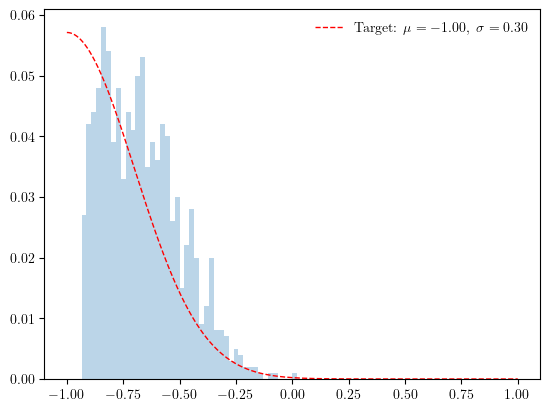

In [32]:
from scipy.stats import norm, truncnorm
from scipy.optimize import fmin_slsqp


# print(len(Strack))
tau = 1000
x = np.linspace(-1, 1, bin_cnt*10)
ct = 1#norm.cdf(max(Strack), mu_t, std_t)#-norm.cdf(min(Strack), mu_t, std_t) # + 
#ct = 1 - norm.cdf(min(Strack), mu_t, std_t)
print(ct)
pt = norm.pdf(x, mu_t, std_t)
pt = pt / np.sum(pt)
plt.plot(
    x,
    pt*10/ct,
    "r--",
    linewidth=1,
    label=r"Target: $\mu={:.2f},~\sigma={:.2f}$".format(mu_t, std_t),
)


weights = np.ones_like(Strack[::tau]) / len(Strack[::tau])
count, bins, _ = plt.hist(
    Strack[::tau], bins=np.linspace(-1, 1, bin_cnt), weights=weights, alpha=0.3
)
#plt.ylim([0, max(count)])
#plt.xlim([min(Strack[::tau]), max(Strack[::tau])*1.1])
plt.legend(frameon=False)